# A simple example for machine learning with uproot / coffea

Let's try to distinguish DY from tt with just using rather low level inputs, and then compare to a simple M(ll) based discriminator.

In [1]:
import uproot
import awkward as ak
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import tensorflow as tf

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import Weights, PackedSelection

In [2]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split

In [3]:

# Load some prepared data
sig_file = "/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.3/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8_RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/nanoSkim_1.root"
bkg_file = "/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.3/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8_RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/nanoSkim_1.root"

sig = NanoEventsFactory.from_root(bkg_file, schemaclass = NanoAODSchema, entry_stop = int(5e5)).events()
bkg = NanoEventsFactory.from_root(sig_file, schemaclass = NanoAODSchema, entry_stop = int(5e5)).events()

print ("Have %s signal events and %s background events"%(len(sig), len(bkg)))


Have 500000 signal events and 500000 background events


In [4]:
from Tools.objects import Collections, choose
from Tools.basic_objects import getJets

In [5]:
def convertToDF( df ):

    electrons = Collections(df, 'Electron', 'tightTTH', verbose=0).get()
    muons = Collections(df, 'Muon', 'tightTTH', verbose=0).get()
        
    jets = getJets(df)
    
    eventSelection = ( ((ak.num(electrons, axis=1) + ak.num(muons, axis=1))==2) & (ak.num(jets, axis=1)>0)  )
    
    df = df[eventSelection]
    jets = jets[eventSelection]
    electrons = electrons[eventSelection]
    muons = muons[eventSelection]
    
    leptons = ak.concatenate([electrons, muons], axis=1)

    leading_jet_idx = ak.singletons(ak.argmax(jets.pt, axis=1))
    leading_jet = jets[leading_jet_idx]
    
    leading_lepton_idx = ak.singletons(ak.argmax(leptons.pt, axis=1))
    trailing_lepton_idx = ak.singletons(ak.argmin(leptons.pt, axis=1))
    
    leading_lepton = leptons[leading_lepton_idx]
    
    trailing_lepton = leptons[trailing_lepton_idx] # this works because we select events with just two leptons in the end
    
    dileptons = choose(leptons,2)
    
    return pd.DataFrame({
            'leadingJet_pt': ak.flatten(leading_jet.pt, axis=1), 
            'lep0_pt': ak.flatten(leading_lepton.pt, axis=1),
            'lep0_eta': ak.flatten(leading_lepton.eta, axis=1),
            'lep0_phi': ak.flatten(leading_lepton.phi, axis=1),
            'lep0_mass': ak.flatten(leading_lepton.mass, axis=1),
            'lep1_pt': ak.flatten(trailing_lepton.pt, axis=1),
            'lep1_eta': ak.flatten(trailing_lepton.eta, axis=1),
            'lep1_phi': ak.flatten(trailing_lepton.phi, axis=1),
            'lep1_mass': ak.flatten(trailing_lepton.mass, axis=1),
            'mll': ak.flatten(dileptons.mass, axis=1), 
            'dilepton_pt': ak.flatten(dileptons.pt, axis=1),
            'MET_pt': df.MET.pt,
    })




In [6]:
sig_df = convertToDF( sig )
bkg_df = convertToDF( bkg )

In [7]:
# usually we have less signal than background
nSignal = len(sig_df)
nBkg = len(bkg_df)

# Balance the signal and background sets
if nBkg>nSignal:
    tmp_bkg_df = bkg_df.sample( n = nSignal )
    tmp_sig_df = sig_df
else:
    tmp_bkg_df = bkg_df
    tmp_sig_df = sig_df.sample( n = nBkg )
    
y_sig = np.ones(len(tmp_sig_df))
y_bkg = np.zeros(len(tmp_bkg_df))
y_tmp = np.concatenate((y_sig,y_bkg))

# merge signal and background
frames = [tmp_sig_df, tmp_bkg_df]
X_tmp = pd.concat(frames)

In [8]:
# Splitting in training and test samples
X_tmp_train, X_tmp_test, y_train, y_test = train_test_split(X_tmp, y_tmp, train_size= int( 0.5*y_tmp.shape[0] ), random_state=42 )

In [9]:
variables = ['lep0_pt', 'lep0_eta', 'lep0_phi', 'lep1_pt', 'lep1_eta', 'lep1_phi']

X_train = X_tmp_train[variables]
X_test = X_tmp_test[variables]
X_myTest = X_tmp_test[['mll', 'MET_pt']]

In [10]:
NHLayer = 5
epochs = 500
batch_size = 5120
validation_split = 0.2

# define the model. Which one is the best suited for our problem?
model = tf.keras.models.Sequential()

# add layers. we can play a bit with the hyper parameters here
model.add( tf.keras.layers.Dense(units=8, activation='relu', input_dim=X_train.shape[1], ))
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )

model.add( tf.keras.layers.Dense(units=64, activation='relu' ) )
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )

model.add( tf.keras.layers.Dense(units=128, activation='relu' ) )
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )

model.add( tf.keras.layers.Dense(units=64, activation='relu' ) )
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )

model.add( tf.keras.layers.Dense(units=8, activation='relu' ) )
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )

model.add( tf.keras.layers.Dense(units=1, activation='sigmoid' ) ) 

# compile the model
model.compile( loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

model.summary()

## Editor's note: don't go too crazy with nodes and layers if the data set is small or nothing will be learned at all.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 56        
_________________________________________________________________
dense_1 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 17,737
Trainable params: 17,737
Non-trainable params: 0
____________________________________________________

In [11]:
# verbose set to 0 (1 shows all the epochs)

history = model.fit(X_train.values, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=0)
model.save( 'training.h5a' )

INFO:tensorflow:Assets written to: training.h5a/assets


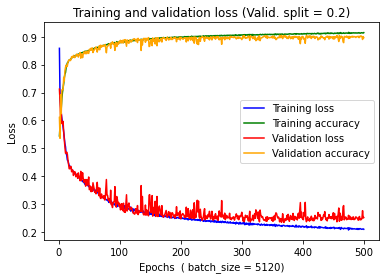

In [12]:
history_dict = history.history

loss_values  = history_dict['loss']
acc_values = history_dict['acc']

epochslist = range(1,  len(loss_values)+1)
        
plt.plot(epochslist, loss_values, 'blue', label='Training loss')
plt.plot(epochslist, acc_values,'green', label='Training accuracy')
try:
    val_loss_values = history_dict['val_loss']
    plt.plot(epochslist, val_loss_values, 'red', label='Validation loss')
    val_acc_values = history_dict['val_acc']
    plt.plot(epochslist, val_acc_values, 'orange', label='Validation accuracy')
except KeyError:
    print ("Didn't find validation loss")

plt.title('Training and validation loss (Valid. split = ' + str( validation_split ) + ')')
plt.xlabel('Epochs  ( batch_size = ' + str( batch_size ) + ')')
plt.ylabel('Loss')
plt.legend()

In [13]:
# use the model to predict whether an event is signal or background
y_test_pred = pd.DataFrame( model.predict( X_test.values  ) , index = X_test.index)

# as a comparison, use a mll based discriminator:
y_test_pred_mll = (1-abs(X_myTest[['mll']]-91.2)/91.2).values.flatten()

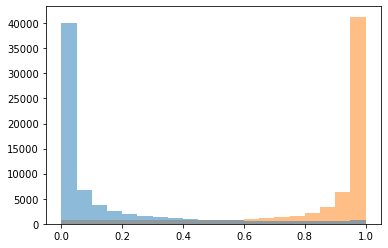

In [14]:
xbin = 20
hist, bins, ax = plt.hist( [
    y_test_pred[y_test==0].values.flatten(),
    y_test_pred[y_test==1].values.flatten(),
], xbin, log=False, label=['Background ('+ str((y_test==0).sum()) +')' ,'Signal ('+ str((y_test==1).sum()) +')'], histtype='stepfilled', alpha=0.5) 

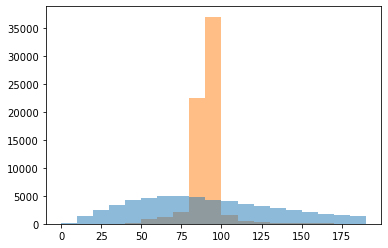

In [15]:
# just looking at M(ll)

xbin = range(0,200,10)
hist, bins, ax = plt.hist( [
    X_myTest[['mll']][y_test==0].values.flatten(),
    X_myTest[['mll']][y_test==1].values.flatten(),
], xbin, log=False, histtype='stepfilled', alpha=0.5) 

In [16]:
#print(y_test_pred[y_test==0].values)
#print(y_test_pred[y_test==1].values)
print(y_test_pred[y_test==0].size)
print(y_test_pred[y_test==1].size)

67358
66940


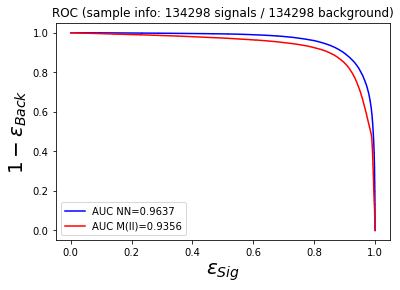

In [17]:
fpr_test, tpr_test, thresholds_test = roc_curve( y_test, y_test_pred )
auc_val_test = auc(fpr_test, tpr_test)

plt.plot( tpr_test, 1-fpr_test, color='blue', label= 'AUC NN=' + str(round(auc_val_test,4) ))

fpr_test_alt, tpr_test_alt, thresholds_test_alt = roc_curve( y_test, y_test_pred_mll )
auc_val_test_alt = auc(fpr_test_alt, tpr_test_alt)

plt.plot( tpr_test_alt, 1-fpr_test_alt, label= 'AUC M(ll)=' + str(round(auc_val_test_alt,4) ), color='red')

plt.title('ROC (sample info: ' + str( len( X_test[y_test == 1] ) + len( X_train[y_train == 1] ) ) + ' signals / '
                                              + str( len( X_test[y_test == 0] ) + len( X_train[y_train == 0] ) ) + ' background)'  )
plt.xlabel('$\epsilon_{Sig}$', fontsize = 20) # 'False positive rate'
plt.ylabel('$1-\epsilon_{Back}$', fontsize = 20) #  '1-True positive rate' 
plt.legend(loc ='lower left')


Some observations:
- with small data set, the performance deterioates pretty quickly when the network becomes too complicated
- without using the lepton charge, the NN underperforms wrt M(ll), but gets quite close once the hyper parameters are (roughly) optimized
- overtraining seems to be not a big problem, and one can use a large number of epochs
- we still use a small data set
- maybe a different model is better suited for our problem?



# Using some physics knowledge (4 vectors)

We can try to use a network that knows about 4 vectors.

This is WIP!


In [51]:
from lbn import LBN, LBNLayer

In [80]:
def convertTo4Vec( df ):
    
    electrons = Collections(df, 'Electron', 'tightTTH', verbose=0).get()
    muons = Collections(df, 'Muon', 'tightTTH', verbose=0).get()
        
    jets = getJets(df)
    
    eventSelection = ( ((ak.num(electrons, axis=1) + ak.num(muons, axis=1))==2) & (ak.num(jets, axis=1)>0)  )
    
    df = df[eventSelection]
    jets = jets[eventSelection]
    electrons = electrons[eventSelection]
    muons = muons[eventSelection]
    
    leptons = ak.concatenate([electrons, muons], axis=1)
    
    en = ak.concatenate([electrons.energy, muons.energy], axis=1)
    px = ak.concatenate([electrons.px, muons.px], axis=1)
    py = ak.concatenate([electrons.py, muons.py], axis=1)
    pz = ak.concatenate([electrons.pz, muons.pz], axis=1)

    leading_jet_idx = ak.singletons(ak.argmax(jets.pt, axis=1))
    leading_jet = jets[leading_jet_idx]
    
    leading_lepton_idx = ak.singletons(ak.argmax(leptons.pt, axis=1))
    trailing_lepton_idx = ak.singletons(ak.argmin(leptons.pt, axis=1))
      
    dileptons = choose(leptons,2)
       
    leading = np.array(list(zip(
        ak.flatten(en[leading_lepton_idx]),
        ak.flatten(px[leading_lepton_idx]),
        ak.flatten(py[leading_lepton_idx]),
        ak.flatten(pz[leading_lepton_idx]),
    )))
    
    trailing = np.array(list(zip(
        ak.flatten(en[trailing_lepton_idx]),
        ak.flatten(px[trailing_lepton_idx]),
        ak.flatten(py[trailing_lepton_idx]),
        ak.flatten(pz[trailing_lepton_idx]),
    )))

    leps = np.array(list(zip(leading, trailing)))
    
    return leps # not yet sure how to do this. have to zip?

In [81]:
sig = NanoEventsFactory.from_root(bkg_file, schemaclass = NanoAODSchema, entry_stop = int(5e5)).events()
bkg = NanoEventsFactory.from_root(sig_file, schemaclass = NanoAODSchema, entry_stop = int(5e5)).events()

inputs_sig = convertTo4Vec( sig )
inputs_bkg = convertTo4Vec( bkg )

nSignal = len(inputs_sig)

# training
inputs_sig_train = inputs_sig[:int(nSignal/2)]
inputs_bkg_train = inputs_bkg[:int(nSignal/2)]

inputs = np.concatenate((inputs_sig_train,inputs_bkg_train))

# test
inputs_sig_test = inputs_sig[int(nSignal/2):nSignal]
inputs_bkg_test = inputs_bkg[int(nSignal/2):nSignal]

inputs_test = np.concatenate((inputs_sig_test,inputs_bkg_test))


# training
y_sig = np.ones(len(inputs_sig_train))
y_bkg = np.zeros(len(inputs_bkg_train))
y_tmp = np.concatenate((y_sig,y_bkg))

# test
y_sig_test = np.ones(len(inputs_sig_test))
y_bkg_test = np.zeros(len(inputs_bkg_test))
y_test = np.concatenate((y_sig_test,y_bkg_test))

print (np.shape(inputs))
print (np.shape(y_tmp))


## Electron selection for WP tightTTH ##
 - pt >= 10
 - abs(etaSC) <= 2.5
 - abs(dxy) <= 0.05
 - abs(dz) <= 0.1
 - abs(sip3d) <= 8.0
 - miniPFRelIso_all <= 0.4
 - sieie <= 0.03
 - hoe <= 0.1
 - eInvMinusPInv >= -0.04
 - convVeto == 1
 - lostHits == 0
 - mvaFall17V2noIso_WPL == 1
 - deepJet <= 0.277
 - mvaTTH >= 0.8
 - SigmaIEtaIEta
Found 216900 objects passing the selection

## Muon selection for WP tightTTH ##
 - pt >= 10
 - abs(eta) <= 2.4
 - mediumId == 1
 - looseId == 1
 - abs(dxy) <= 0.05
 - abs(dz) <= 0.1
 - abs(sip3d) <= 8
 - miniPFRelIso_all <= 0.4
 - mvaTTH >= 0.85
 - deepJet <= 0.277
Found 458367 objects passing the selection

## Electron selection for WP tightTTH ##
 - pt >= 10
 - abs(etaSC) <= 2.5
 - abs(dxy) <= 0.05
 - abs(dz) <= 0.1
 - abs(sip3d) <= 8.0
 - miniPFRelIso_all <= 0.4
 - sieie <= 0.03
 - hoe <= 0.1
 - eInvMinusPInv >= -0.04
 - convVeto == 1
 - lostHits == 0
 - mvaFall17V2noIso_WPL == 1
 - deepJet <= 0.277
 - mvaTTH >= 0.8
 - SigmaIEtaIEta
Found 180135 objects

In [82]:
# start a sequential model
model = tf.keras.models.Sequential()

# add the LBN layer
lbn_layer = LBNLayer((2, 4), n_particles=2, boost_mode=LBN.PAIRS, features=["E", "px", "py", "pz"])

model.add(lbn_layer)

model.add( tf.keras.layers.Dense(units=8, activation='relu' ) )
model.add( tf.keras.layers.Dense(units=64, activation='relu' ) )
model.add( tf.keras.layers.Dense(units=8, activation='relu' ) )

model.add( tf.keras.layers.Dense(units=1, activation='sigmoid' ) ) 

# compile the model
model.compile( loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

#model.compile(loss="categorical_crossentropy")

features = model.predict(inputs)

In [83]:
history = model.fit(inputs, y_tmp, epochs=1000, batch_size=batch_size, validation_split=validation_split)

Epoch 1/1000
41/41 [==============================] - 2s 26ms/step - loss: 0.8591 - acc: 0.5740 - val_loss: 0.6544 - val_acc: 0.5300
Epoch 2/1000
41/41 [==============================] - 1s 19ms/step - loss: 0.6743 - acc: 0.6085 - val_loss: 1.1329 - val_acc: 0.1458
Epoch 3/1000
41/41 [==============================] - 1s 19ms/step - loss: 0.6600 - acc: 0.6227 - val_loss: 0.6458 - val_acc: 0.4946
Epoch 4/1000
41/41 [==============================] - 1s 18ms/step - loss: 0.6502 - acc: 0.6350 - val_loss: 1.0818 - val_acc: 0.1646
Epoch 5/1000
41/41 [==============================] - 1s 18ms/step - loss: 0.6411 - acc: 0.6502 - val_loss: 0.6702 - val_acc: 0.4567
Epoch 6/1000
41/41 [==============================] - 1s 18ms/step - loss: 0.6354 - acc: 0.6579 - val_loss: 1.0875 - val_acc: 0.1616
Epoch 7/1000
41/41 [==============================] - 1s 18ms/step - loss: 0.6278 - acc: 0.6696 - val_loss: 0.8643 - val_acc: 0.2775
Epoch 8/1000
41/41 [==============================] - 1s 16ms/step - 

41/41 [==============================] - 1s 17ms/step - loss: 0.3160 - acc: 0.8781 - val_loss: 0.4301 - val_acc: 0.8017
Epoch 63/1000
41/41 [==============================] - 1s 17ms/step - loss: 0.3144 - acc: 0.8795 - val_loss: 0.4451 - val_acc: 0.8001
Epoch 64/1000
41/41 [==============================] - 1s 18ms/step - loss: 0.3133 - acc: 0.8796 - val_loss: 0.4199 - val_acc: 0.8116
Epoch 65/1000
41/41 [==============================] - 1s 17ms/step - loss: 0.3115 - acc: 0.8804 - val_loss: 0.5076 - val_acc: 0.7833
Epoch 66/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.3109 - acc: 0.8808 - val_loss: 0.4755 - val_acc: 0.7953
Epoch 67/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.3091 - acc: 0.8812 - val_loss: 0.3703 - val_acc: 0.8378
Epoch 68/1000
41/41 [==============================] - 1s 16ms/step - loss: 0.3079 - acc: 0.8816 - val_loss: 0.4020 - val_acc: 0.8237
Epoch 69/1000
41/41 [==============================] - 1s 16ms/step - loss: 

41/41 [==============================] - 1s 17ms/step - loss: 0.2909 - acc: 0.8845 - val_loss: 0.4926 - val_acc: 0.8234
Epoch 124/1000
41/41 [==============================] - 1s 17ms/step - loss: 0.2908 - acc: 0.8845 - val_loss: 0.4164 - val_acc: 0.8449
Epoch 125/1000
41/41 [==============================] - 1s 17ms/step - loss: 0.2905 - acc: 0.8848 - val_loss: 0.4263 - val_acc: 0.8438
Epoch 126/1000
41/41 [==============================] - 1s 17ms/step - loss: 0.2909 - acc: 0.8847 - val_loss: 0.5105 - val_acc: 0.8169
Epoch 127/1000
41/41 [==============================] - 1s 17ms/step - loss: 0.2902 - acc: 0.8847 - val_loss: 0.4590 - val_acc: 0.8332
Epoch 128/1000
41/41 [==============================] - 1s 18ms/step - loss: 0.2894 - acc: 0.8845 - val_loss: 0.4399 - val_acc: 0.8373
Epoch 129/1000
41/41 [==============================] - 1s 18ms/step - loss: 0.2904 - acc: 0.8849 - val_loss: 0.4136 - val_acc: 0.8475
Epoch 130/1000
41/41 [==============================] - 1s 17ms/step -

Epoch 184/1000
41/41 [==============================] - 1s 17ms/step - loss: 0.2889 - acc: 0.8852 - val_loss: 0.3979 - val_acc: 0.8490
Epoch 185/1000
41/41 [==============================] - 1s 17ms/step - loss: 0.2879 - acc: 0.8851 - val_loss: 0.3748 - val_acc: 0.8600
Epoch 186/1000
41/41 [==============================] - 1s 17ms/step - loss: 0.2882 - acc: 0.8850 - val_loss: 0.4224 - val_acc: 0.8418
Epoch 187/1000
41/41 [==============================] - 1s 16ms/step - loss: 0.2884 - acc: 0.8846 - val_loss: 0.3622 - val_acc: 0.8636
Epoch 188/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.2884 - acc: 0.8851 - val_loss: 0.3907 - val_acc: 0.8524
Epoch 189/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.2881 - acc: 0.8851 - val_loss: 0.3899 - val_acc: 0.8508
Epoch 190/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.2882 - acc: 0.8851 - val_loss: 0.4785 - val_acc: 0.8218
Epoch 191/1000
41/41 [==============================] -

Epoch 245/1000
41/41 [==============================] - 1s 17ms/step - loss: 0.2869 - acc: 0.8851 - val_loss: 0.3502 - val_acc: 0.8672
Epoch 246/1000
41/41 [==============================] - 1s 17ms/step - loss: 0.2873 - acc: 0.8852 - val_loss: 0.4591 - val_acc: 0.8272
Epoch 247/1000
41/41 [==============================] - 1s 16ms/step - loss: 0.2871 - acc: 0.8852 - val_loss: 0.3802 - val_acc: 0.8569
Epoch 248/1000
41/41 [==============================] - 1s 17ms/step - loss: 0.2866 - acc: 0.8853 - val_loss: 0.4132 - val_acc: 0.8497
Epoch 249/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.2869 - acc: 0.8855 - val_loss: 0.3567 - val_acc: 0.8624
Epoch 250/1000
41/41 [==============================] - 1s 14ms/step - loss: 0.2870 - acc: 0.8850 - val_loss: 0.4497 - val_acc: 0.8311
Epoch 251/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.2867 - acc: 0.8849 - val_loss: 0.3900 - val_acc: 0.8554
Epoch 252/1000
41/41 [==============================] -

Epoch 306/1000
41/41 [==============================] - 1s 16ms/step - loss: 0.2856 - acc: 0.8855 - val_loss: 0.4779 - val_acc: 0.8202
Epoch 307/1000
41/41 [==============================] - 1s 17ms/step - loss: 0.2861 - acc: 0.8852 - val_loss: 0.4452 - val_acc: 0.8359
Epoch 308/1000
41/41 [==============================] - 1s 14ms/step - loss: 0.2862 - acc: 0.8853 - val_loss: 0.3875 - val_acc: 0.8547
Epoch 309/1000
41/41 [==============================] - 1s 17ms/step - loss: 0.2870 - acc: 0.8850 - val_loss: 0.4284 - val_acc: 0.8397
Epoch 310/1000
41/41 [==============================] - 1s 17ms/step - loss: 0.2860 - acc: 0.8855 - val_loss: 0.4242 - val_acc: 0.8423
Epoch 311/1000
41/41 [==============================] - 1s 18ms/step - loss: 0.2864 - acc: 0.8852 - val_loss: 0.4597 - val_acc: 0.8270
Epoch 312/1000
41/41 [==============================] - 1s 18ms/step - loss: 0.2864 - acc: 0.8848 - val_loss: 0.4087 - val_acc: 0.8402
Epoch 313/1000
41/41 [==============================] -

Epoch 367/1000
41/41 [==============================] - 1s 17ms/step - loss: 0.2858 - acc: 0.8851 - val_loss: 0.4018 - val_acc: 0.8522
Epoch 368/1000
41/41 [==============================] - 1s 16ms/step - loss: 0.2859 - acc: 0.8854 - val_loss: 0.3528 - val_acc: 0.8689
Epoch 369/1000
41/41 [==============================] - 1s 17ms/step - loss: 0.2856 - acc: 0.8852 - val_loss: 0.4427 - val_acc: 0.8329
Epoch 370/1000
41/41 [==============================] - 1s 13ms/step - loss: 0.2852 - acc: 0.8854 - val_loss: 0.4536 - val_acc: 0.8297
Epoch 371/1000
41/41 [==============================] - 1s 14ms/step - loss: 0.2854 - acc: 0.8857 - val_loss: 0.5052 - val_acc: 0.8148
Epoch 372/1000
41/41 [==============================] - 1s 16ms/step - loss: 0.2861 - acc: 0.8854 - val_loss: 0.3898 - val_acc: 0.8511
Epoch 373/1000
41/41 [==============================] - 1s 17ms/step - loss: 0.2853 - acc: 0.8855 - val_loss: 0.3738 - val_acc: 0.8597
Epoch 374/1000
41/41 [==============================] -

Epoch 428/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.2855 - acc: 0.8854 - val_loss: 0.4212 - val_acc: 0.8389
Epoch 429/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.2860 - acc: 0.8853 - val_loss: 0.4323 - val_acc: 0.8394
Epoch 430/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.2853 - acc: 0.8853 - val_loss: 0.4610 - val_acc: 0.8276
Epoch 431/1000
41/41 [==============================] - 1s 16ms/step - loss: 0.2858 - acc: 0.8854 - val_loss: 0.4668 - val_acc: 0.8266
Epoch 432/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.2851 - acc: 0.8856 - val_loss: 0.4668 - val_acc: 0.8266
Epoch 433/1000
41/41 [==============================] - 1s 16ms/step - loss: 0.2853 - acc: 0.8856 - val_loss: 0.4385 - val_acc: 0.8334
Epoch 434/1000
41/41 [==============================] - 1s 16ms/step - loss: 0.2854 - acc: 0.8856 - val_loss: 0.3913 - val_acc: 0.8499
Epoch 435/1000
41/41 [==============================] -

Epoch 489/1000
41/41 [==============================] - 1s 16ms/step - loss: 0.2852 - acc: 0.8852 - val_loss: 0.4459 - val_acc: 0.8335
Epoch 490/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.2853 - acc: 0.8855 - val_loss: 0.4224 - val_acc: 0.8432
Epoch 491/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.2847 - acc: 0.8856 - val_loss: 0.4551 - val_acc: 0.8314
Epoch 492/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.2855 - acc: 0.8855 - val_loss: 0.4441 - val_acc: 0.8298
Epoch 493/1000
41/41 [==============================] - 1s 14ms/step - loss: 0.2855 - acc: 0.8857 - val_loss: 0.3892 - val_acc: 0.8511
Epoch 494/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.2851 - acc: 0.8853 - val_loss: 0.4206 - val_acc: 0.8424
Epoch 495/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.2852 - acc: 0.8859 - val_loss: 0.3653 - val_acc: 0.8634
Epoch 496/1000
41/41 [==============================] -

Epoch 550/1000
41/41 [==============================] - 1s 18ms/step - loss: 0.2854 - acc: 0.8853 - val_loss: 0.3911 - val_acc: 0.8513
Epoch 551/1000
41/41 [==============================] - 1s 18ms/step - loss: 0.2850 - acc: 0.8854 - val_loss: 0.4190 - val_acc: 0.8392
Epoch 552/1000
41/41 [==============================] - 1s 17ms/step - loss: 0.2852 - acc: 0.8853 - val_loss: 0.4122 - val_acc: 0.8494
Epoch 553/1000
41/41 [==============================] - 1s 14ms/step - loss: 0.2848 - acc: 0.8855 - val_loss: 0.4239 - val_acc: 0.8379
Epoch 554/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.2851 - acc: 0.8852 - val_loss: 0.3935 - val_acc: 0.8504
Epoch 555/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.2847 - acc: 0.8859 - val_loss: 0.4404 - val_acc: 0.8344
Epoch 556/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.2848 - acc: 0.8854 - val_loss: 0.4167 - val_acc: 0.8431
Epoch 557/1000
41/41 [==============================] -

Epoch 611/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.2842 - acc: 0.8854 - val_loss: 0.4329 - val_acc: 0.8336
Epoch 612/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.2849 - acc: 0.8855 - val_loss: 0.4380 - val_acc: 0.8343
Epoch 613/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.2845 - acc: 0.8854 - val_loss: 0.4452 - val_acc: 0.8324
Epoch 614/1000
41/41 [==============================] - 1s 16ms/step - loss: 0.2846 - acc: 0.8857 - val_loss: 0.4248 - val_acc: 0.8424
Epoch 615/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.2846 - acc: 0.8857 - val_loss: 0.4450 - val_acc: 0.8353
Epoch 616/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.2844 - acc: 0.8858 - val_loss: 0.4109 - val_acc: 0.8462
Epoch 617/1000
41/41 [==============================] - 1s 14ms/step - loss: 0.2846 - acc: 0.8858 - val_loss: 0.3822 - val_acc: 0.8554
Epoch 618/1000
41/41 [==============================] -

Epoch 672/1000
41/41 [==============================] - 1s 14ms/step - loss: 0.2848 - acc: 0.8855 - val_loss: 0.4191 - val_acc: 0.8429
Epoch 673/1000
41/41 [==============================] - 1s 13ms/step - loss: 0.2846 - acc: 0.8856 - val_loss: 0.4017 - val_acc: 0.8483
Epoch 674/1000
41/41 [==============================] - 1s 14ms/step - loss: 0.2845 - acc: 0.8855 - val_loss: 0.3940 - val_acc: 0.8530
Epoch 675/1000
41/41 [==============================] - 1s 14ms/step - loss: 0.2843 - acc: 0.8855 - val_loss: 0.4440 - val_acc: 0.8390
Epoch 676/1000
41/41 [==============================] - 1s 14ms/step - loss: 0.2847 - acc: 0.8855 - val_loss: 0.3819 - val_acc: 0.8562
Epoch 677/1000
41/41 [==============================] - 1s 16ms/step - loss: 0.2847 - acc: 0.8857 - val_loss: 0.4266 - val_acc: 0.8408
Epoch 678/1000
41/41 [==============================] - 1s 14ms/step - loss: 0.2848 - acc: 0.8853 - val_loss: 0.4358 - val_acc: 0.8375
Epoch 679/1000
41/41 [==============================] -

Epoch 733/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.2844 - acc: 0.8853 - val_loss: 0.4038 - val_acc: 0.8498
Epoch 734/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.2846 - acc: 0.8857 - val_loss: 0.4267 - val_acc: 0.8403
Epoch 735/1000
41/41 [==============================] - 1s 16ms/step - loss: 0.2842 - acc: 0.8860 - val_loss: 0.4421 - val_acc: 0.8375
Epoch 736/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.2846 - acc: 0.8856 - val_loss: 0.3938 - val_acc: 0.8556
Epoch 737/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.2841 - acc: 0.8855 - val_loss: 0.4294 - val_acc: 0.8423
Epoch 738/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.2845 - acc: 0.8856 - val_loss: 0.4724 - val_acc: 0.8276
Epoch 739/1000
41/41 [==============================] - 1s 16ms/step - loss: 0.2848 - acc: 0.8856 - val_loss: 0.4415 - val_acc: 0.8367
Epoch 740/1000
41/41 [==============================] -

Epoch 794/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.2846 - acc: 0.8857 - val_loss: 0.3655 - val_acc: 0.8633
Epoch 795/1000
41/41 [==============================] - 1s 16ms/step - loss: 0.2845 - acc: 0.8855 - val_loss: 0.3707 - val_acc: 0.8613
Epoch 796/1000
41/41 [==============================] - 1s 18ms/step - loss: 0.2842 - acc: 0.8858 - val_loss: 0.4284 - val_acc: 0.8426
Epoch 797/1000
41/41 [==============================] - 1s 18ms/step - loss: 0.2843 - acc: 0.8859 - val_loss: 0.4616 - val_acc: 0.8361
Epoch 798/1000
41/41 [==============================] - 1s 17ms/step - loss: 0.2846 - acc: 0.8855 - val_loss: 0.4005 - val_acc: 0.8496
Epoch 799/1000
41/41 [==============================] - 1s 18ms/step - loss: 0.2844 - acc: 0.8857 - val_loss: 0.3931 - val_acc: 0.8528
Epoch 800/1000
41/41 [==============================] - 1s 18ms/step - loss: 0.2846 - acc: 0.8856 - val_loss: 0.3934 - val_acc: 0.8517
Epoch 801/1000
41/41 [==============================] -

Epoch 855/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.2841 - acc: 0.8854 - val_loss: 0.4361 - val_acc: 0.8398
Epoch 856/1000
41/41 [==============================] - 1s 17ms/step - loss: 0.2844 - acc: 0.8853 - val_loss: 0.4189 - val_acc: 0.8466
Epoch 857/1000
41/41 [==============================] - 1s 17ms/step - loss: 0.2845 - acc: 0.8858 - val_loss: 0.4050 - val_acc: 0.8487
Epoch 858/1000
41/41 [==============================] - 1s 16ms/step - loss: 0.2841 - acc: 0.8856 - val_loss: 0.4036 - val_acc: 0.8502
Epoch 859/1000
41/41 [==============================] - 1s 16ms/step - loss: 0.2843 - acc: 0.8853 - val_loss: 0.4011 - val_acc: 0.8525
Epoch 860/1000
41/41 [==============================] - 1s 18ms/step - loss: 0.2843 - acc: 0.8856 - val_loss: 0.4497 - val_acc: 0.8366
Epoch 861/1000
41/41 [==============================] - 1s 17ms/step - loss: 0.2839 - acc: 0.8859 - val_loss: 0.4355 - val_acc: 0.8394
Epoch 862/1000
41/41 [==============================] -

Epoch 916/1000
41/41 [==============================] - 1s 18ms/step - loss: 0.2841 - acc: 0.8857 - val_loss: 0.4075 - val_acc: 0.8466
Epoch 917/1000
41/41 [==============================] - 1s 17ms/step - loss: 0.2841 - acc: 0.8856 - val_loss: 0.3685 - val_acc: 0.8618
Epoch 918/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.2843 - acc: 0.8856 - val_loss: 0.4274 - val_acc: 0.8438
Epoch 919/1000
41/41 [==============================] - 1s 16ms/step - loss: 0.2842 - acc: 0.8858 - val_loss: 0.4305 - val_acc: 0.8428
Epoch 920/1000
41/41 [==============================] - 1s 16ms/step - loss: 0.2842 - acc: 0.8857 - val_loss: 0.3964 - val_acc: 0.8514
Epoch 921/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.2843 - acc: 0.8857 - val_loss: 0.3902 - val_acc: 0.8497
Epoch 922/1000
41/41 [==============================] - 1s 15ms/step - loss: 0.2842 - acc: 0.8858 - val_loss: 0.3925 - val_acc: 0.8531
Epoch 923/1000
41/41 [==============================] -

Epoch 977/1000
41/41 [==============================] - 1s 16ms/step - loss: 0.2841 - acc: 0.8857 - val_loss: 0.4190 - val_acc: 0.8430
Epoch 978/1000
41/41 [==============================] - 1s 16ms/step - loss: 0.2839 - acc: 0.8858 - val_loss: 0.4036 - val_acc: 0.8513
Epoch 979/1000
41/41 [==============================] - 1s 17ms/step - loss: 0.2841 - acc: 0.8858 - val_loss: 0.4140 - val_acc: 0.8438
Epoch 980/1000
41/41 [==============================] - 1s 16ms/step - loss: 0.2838 - acc: 0.8859 - val_loss: 0.4490 - val_acc: 0.8360
Epoch 981/1000
41/41 [==============================] - 1s 17ms/step - loss: 0.2839 - acc: 0.8858 - val_loss: 0.4563 - val_acc: 0.8326
Epoch 982/1000
41/41 [==============================] - 1s 16ms/step - loss: 0.2840 - acc: 0.8858 - val_loss: 0.4588 - val_acc: 0.8323
Epoch 983/1000
41/41 [==============================] - 1s 16ms/step - loss: 0.2840 - acc: 0.8857 - val_loss: 0.4527 - val_acc: 0.8341
Epoch 984/1000
41/41 [==============================] -

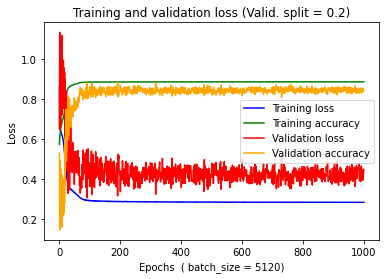

In [94]:
history_dict = history.history

loss_values  = history_dict['loss']
acc_values = history_dict['acc']

epochslist = range(1,  len(loss_values)+1)
        
plt.plot(epochslist, loss_values, color='blue', label='Training loss')
plt.plot(epochslist, acc_values, color='green', label='Training accuracy')
try:
    val_loss_values = history_dict['val_loss']
    plt.plot(epochslist, val_loss_values, color='red', label='Validation loss')
    val_acc_values = history_dict['val_acc']
    plt.plot(epochslist, val_acc_values, color='orange', label='Validation accuracy')
except KeyError:
    print ("Didn't find validation loss")

plt.title('Training and validation loss (Valid. split = ' + str( validation_split ) + ')')
plt.xlabel('Epochs  ( batch_size = ' + str( batch_size ) + ')')
plt.ylabel('Loss')
plt.legend()

In [88]:
y_test_pred = pd.DataFrame( model.predict( inputs_test  ) )
y_train_pred = pd.DataFrame( model.predict( inputs  ) )

In [90]:
fpr_test, tpr_test, thresholds_test = roc_curve( y_test, y_test_pred )
fpr_train, tpr_train, thresholds_train = roc_curve( y_tmp, y_train_pred )

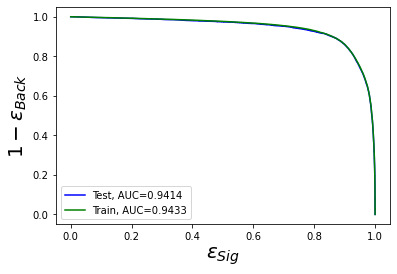

In [93]:
auc_val_test = auc(fpr_test, tpr_test)
auc_val_train = auc(fpr_train, tpr_train)

plt.plot( tpr_test, 1-fpr_test, 'b', label= 'Test, AUC=' + str(round(auc_val_test,4)))
plt.plot( tpr_train, 1-fpr_train, 'g', label= 'Train, AUC=' + str(round(auc_val_train,4)))

#plt.title('ROC (sample info: ' + str( len( X_test[y_test == 1] ) + len( X_train[y_train == 1] ) ) + ' signals / '
#                                              + str( len( X_test[y_test == 0] ) + len( X_train[y_train == 0] ) ) + ' background)'  )
plt.xlabel('$\epsilon_{Sig}$', fontsize = 20) # 'False positive rate'
plt.ylabel('$1-\epsilon_{Back}$', fontsize = 20) #  '1-True positive rate' 
plt.legend(loc ='lower left')